In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install tqdm numpy==1.19.5 torch==1.8.1


Next, set up virtual display，and import all necessaary packages.

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [ ]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [30]:
%%capture
import gym
import gym_connect4_twist_n_turn
import random
env = gym.make('Connect4_Twist_n_Turn-v0', height=5, width=6, connect=4)
#fix(env, seed) # fix the environment Do not revise this !!!

In [31]:
print(env.observation_space)

Tuple(Box(0, 1, (3, 6, 5), int32), Box(0, 1, (3, 6, 5), int32))



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [32]:
print(env.action_space)

MultiDiscrete([ 6 11])


In [33]:
initial_state = env.reset()
print(initial_state)

(array([[[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=uint8), array([[[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=uint8))


/Users/yukai/opt/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/yukai/opt/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/Users/yukai/opt/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/yukai/opt/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array d

Then, we try to get a random action from the agent's action space.

In [34]:
random_action = env.action_space.sample()
print(random_action)

[5 7]


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [35]:
observation, reward, done, info = env.step(random_action)

/Users/yukai/opt/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/yukai/opt/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: uint8
  logger.warn(
/Users/yukai/opt/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:260: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


In [36]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [37]:
print(reward)

[0, 0]


### Random Agent


In [54]:
import gym
import gym_connect4_twist_n_turn
import random
env = gym.make('Connect4_Twist_n_Turn-v0', height=5, width=6, connect=4)
env.reset()

#img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    # action = env.action_space.sample()

    ### Random agent
    all_action = env.get_moves()
    action = [random.choice(all_action[0]),random.choice(all_action[1])]
    ### 

    observation, reward, done, _ = env.step(action)
    # _ is info in my env
env.render()
print(env.winner,done)
print(env.pw(env.winner))
    #img.set_data(env.render(mode='rgb_array'))
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
print(env.board)

......
......
.OX...
XOOX.X
OXXOXO

1 True


AttributeError: 'Connect4_TnT_Env' object has no attribute 'pw'

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        # self.fc1 = nn.Linear(8, 16)
        # self.fc2 = nn.Linear(16, 16)
        # self.fc3 = nn.Linear(16, 4)
        self.conv1 = nn.Conv2d(3,5,3) # 5*6*3 => 3 * 4 * 5
        self.conv2 = nn.Conv2d(5,3,3) # 1 * 2 * 3
        self.fc1 = nn.Linear(6,2)
        

    def forward(self, state):
        hid = torch.tanh(self.conv1(state))
        hid = torch.tanh(hid)
        ret = hid.reshape((6))
        return self.fc1(hid)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [ ]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Lastly, build a network and agent to start training.

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
agent.network.train()  # Switch network into training mode 
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 500        # totally update the agent for 400 time

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) # change here
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                
                break

    print(f"rewards looks like ", np.shape(rewards))  
    #print(f"log_probs looks like ", np.shape(log_probs))     
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


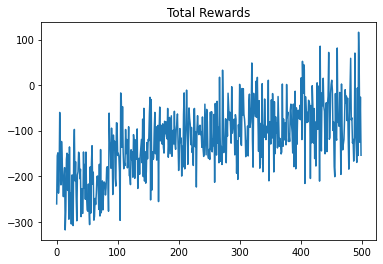

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


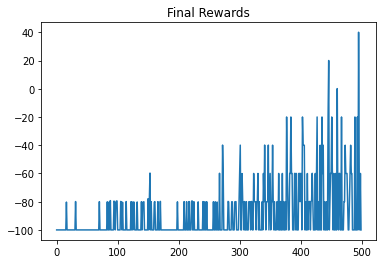

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

-212.10940126884222


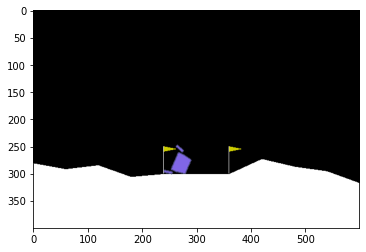

In [ ]:
fix(env, seed)
agent.network.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


In [ ]:
print(np.mean(test_total_reward))

-169.5256750679991


Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2], [2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  When working along a given axis, a slice along that axis is returned in


Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{2: 822, 1: 336, 3: 297, 0: 17}


Saving the result of Model Testing


/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


Your reward is : -56.28
Your reward is : -243.86
Your reward is : -143.49
Your reward is : -191.89
Your reward is : -212.11


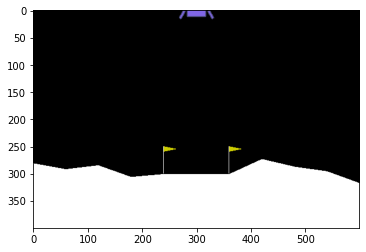

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
